In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import io
import pandas as pd
from plotnine import *
from pulp import *
from wurlitzer import sys_pipes
from typing import Optional, List, Tuple

from Knapsack import make_knapsack_model, KnapsackProblem, plot_knapsack, plot_items

theme_set(theme_bw())

# Knapsack problem

You are given a set of items $I$ with weight $w_i$ and value $p_i$ and a knapsack with capacity (maximum weight) $C$.

Your goal is to fill the knapsack with the available items in $I$ to maximize its total value.
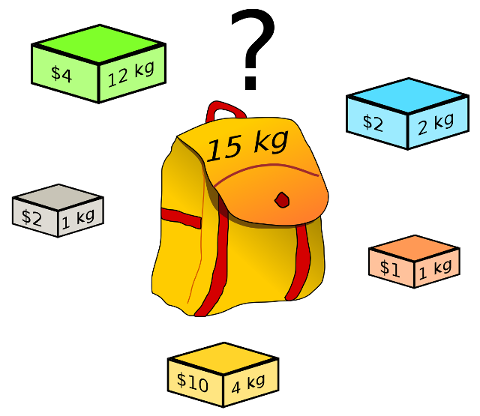

 ## Model

$\newcommand{\var}[1]{{\color{blue}{#1}}}$

Let $\var{x_i}$ be a binary variable for each item $i\in I$ such that $\var{x_i}=1$ iff $i$ is put in the knapsack.

 $$\begin{align}
 \max ~& \sum_{i\in I} p_i \var{x_i}\\
 & \sum_{i\in I} w_i \var{x_i} \le C\\
 & \var{x_i} \in \{0,1\}\quad \forall i\in I
 \end{align}
 $$
 
 ## Python (PuLP) code
 

```python

def make_knapsack_model(items_data: DataFrame, capacity:float) -> LpProblem:
"""
    items_data: items dataframe with columns `weight` and `value`
    capacity: knapsack capacity
"""
    I = list(range(len(items_data)))
    
    model = LpProblem("Knapsack",sense=LpMaximize)

    x = [LpVariable(cat=LpBinary, name=f"x_{i}") for i in I]

    total_value = lpSum(items_data["value"][i] * x[i] for i in I)
    total_weight = lpSum(items_data["weight"][i] * x[i] for i in I)

    model.addConstraint(total_weight <= capacity, "capacity_constraint")

    model.setObjective(total_value)
    
    return model
```

## Example with 10 items

Weight and value randomly distributed between 0 and 1

In [3]:
items = pd.read_csv(io.StringIO("""value,weight
0.852914,0.919548
0.235584,0.037868
0.146313,0.861563
0.589910,0.753593
0.574054,0.405238
0.061364,0.343592
0.590467,0.171000
0.245425,0.394720
0.340511,0.641702
0.984730,0.274665"""))
capacity = 0.45 * items["weight"].sum()

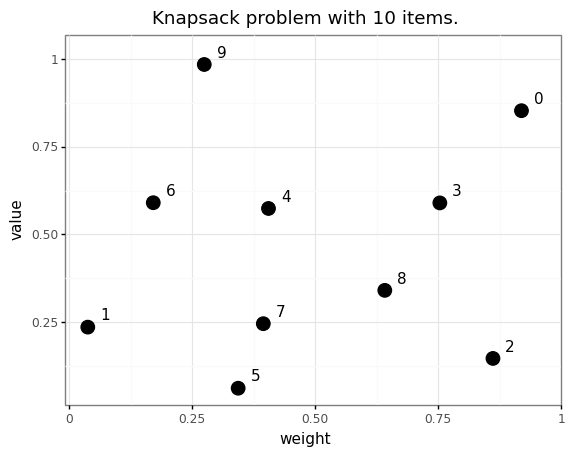

<ggplot: (8732176137569)>

In [4]:
plot_items(items)

### Solve with PuLP/CB

Log will reports the steps/heuristics used by the solver.


In [5]:
kp = make_knapsack_model(items, capacity)

with sys_pipes():
    kp.model.solve()

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ataverna_personal/miniconda3/envs/experiments/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/56df6f0d6ee448ca8cabe1889d2d5e90-pulp.mps max branch printingOptions all solution /tmp/56df6f0d6ee448ca8cabe1889d2d5e90-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 47 RHS
At line 49 BOUNDS
At line 60 ENDATA
Problem MODEL has 1 rows, 10 columns and 10 elements
Coin0008I MODEL read with 0 errors
Continuous objective value is 3.51427 - 0.00 seconds
Cgl0004I processed model has 1 rows, 10 columns (10 integer (10 of which binary)) and 10 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.468756
Cbc0038I Solution found of -3.23775
Cbc0038I Before mini branch and bound, 9 integers at bound fixed and 0 continuous
Cbc0038I Full problem 1 rows 10 columns, reduced to 0 rows 0 columns
Cbc0038I Mini branch and bound di

### Solution

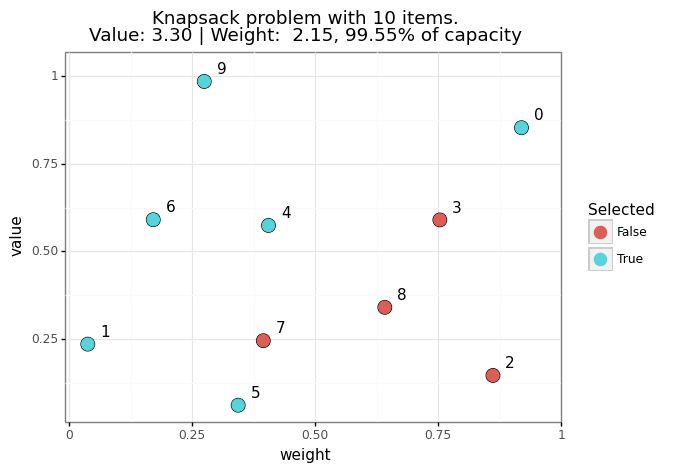

<ggplot: (8732069196876)>

In [6]:
plot_knapsack(kp)

## Interpretabilty/Explainability

The methods we use can be interpreted and explained.

Consider, for example, the following questions about item #8:
1. Why is the item not included in the optimal solution? 
2. What would happen if I was forced to put it in the knapsack?
3. How much should I ask for forcing the item in the knapsack?

We can answer those by forcing the solver to include item #8 in the knapsack

### Add constraint to force #8 selection

In [7]:
kp = make_knapsack_model(items, capacity)
kp.model.addConstraint(kp.x[8] == 1, name="force_select_8")

### Solve the new model

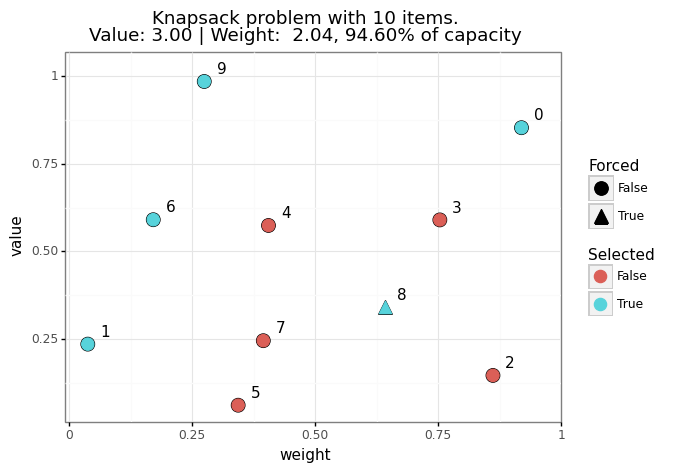

<ggplot: (8732066980060)>

In [8]:
kp.model.solve()

plot_knapsack(kp, force_selected=[8])

### Answers

So now we know item #8 was not put in the knapsack because it would cause a `0.30` value loss w.r.t. the optimal solution. 

Hence, if someone asked to put the item in the knapsack, we should ask for a payment of at least `0.30` to recover losses.

$$\begin{align*}
 \mathrm{P:}~\max ~& c^\top \var{y} + d^\top\var{y} \\
 & A^\top \var{x} + F^\top \var{y} \le b\\
 & \var{x}\in \mathcal{X}\\
 & \var{x}\in \mathcal{Y}
 \end{align*}$$

$\newcommand{\mult}[1]{{\color{red}{#1}}}$

$$\begin{align*}
 \mathrm{R(\mult{\lambda}):}~\max ~& c^\top \var{x} + d^\top\var{y} - \mult{\lambda}^\top (A^\top \var{x} + F^\top \var{y} - b) \\
 & \var{x}\in \mathcal{X}\\
 & \var{y}\in \mathcal{Y}
 \end{align*}$$
 
 
 $$\begin{align*}
 \mathrm{R_x(\mult{\lambda}):}~\max ~& c^\top \var{x} - \mult{\lambda}^\top A^\top \var{x} \\
 & \var{x}\in \mathcal{X}
 \end{align*}$$
 
 
 $$\begin{align*}
 \mathrm{R_y(\mult{\lambda}):}~\max ~& d^\top \var{y} - \mult{\lambda}^\top F^\top \var{y} \\
 & \var{y}\in \mathcal{Y}
 \end{align*}$$

$$\begin{align*}
 \mathrm{P:}~\min ~& c^\top \var{x} \\
 & A^\top \var{x} \ge b\\
 & \var{x}\in \mathcal{X}\\
 \end{align*}
 $$

$$\begin{align*}
 \mathrm{R(\mult{\lambda}):} ~\min_{\var{x}\in \mathcal{X}} ~&  c^\top \var{x} + \mult{\lambda}^\top (b - A^\top \var{x}) 
 \end{align*}$$

$$\begin{align*}
 {\mathrm{D}:} ~\max_{\mult{\lambda} \ge 0} ~\varphi(\mult\lambda) = \min_{\var{x}\in \mathcal{X}} ~& c^\top \var{x} + \mult{\lambda}^\top (b - A^\top \var{x})
 \end{align*}$$
 
 $$ \phi(\mult\lambda)= \mathrm{opt}(\mathrm R(\mult\lambda)) \le \mathrm{opt}(P)\quad \forall \mult\lambda \ge 0$$ 

$$\begin{align}
{{g_n}} & = b - A^\top \var{x_n} \\ 
d_n & = \alpha_n {g_n} + (1-\alpha_n) d_{n-1}\\
s_n & = \beta_n \frac{\hat\varphi_n - \varphi(\mult{\lambda_n})}{\lVert d_n \rVert^2}\\
\mult{\lambda_{n+1}} & = \max(0,\,\mult{\lambda_n} - s_n d_n)\\
\end{align}
$$

$$\begin{align*}
\max ~& \mult{z} \\
& \mult{z} \le c^\top x_{n'} + \mult\lambda^\top(b - A^\top x_{n'})\quad n'\in 1..n\\
& \mult{\lambda} \ge 0\\
& \mult{z} \in \mathbb{R}
\end{align*}
$$